<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/MNISTVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Designing a Variaitonal AutoEncoder
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
import os

In [2]:
# MNIST Data Set
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size= x_train.shape[1]
orig_dim=image_size * image_size

print(x_train.shape)

x_train=np.reshape(x_train, [-1,orig_dim])
x_test=np.reshape(x_test, [-1,orig_dim])
x_train=x_train.astype('float32')/255
x_test=x_test.astype('float32')/255


x_train.shape


(60000, 28, 28)


(60000, 784)

In [3]:
print(image_size)
print(x_train.shape[1])

28
784


In [4]:
# Network Parameters
input_shape=(orig_dim,)
intermediate_dim=512
batch_size=128
latent_dim=2
epochs=50

In [5]:
# Create a Variational AutoEncoder Model = Encoder + Decoder
inputs = Input(shape=input_shape, name='Encoder_input')
x = Dense(intermediate_dim,activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [6]:
# Sampling Method
def sampling(args):
    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normalshape=((batch, dim))
    print(batch)
    print(dim)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon   
     

In [7]:
def plot_results(models, data, batch_size=128, model_name='VAE_MNIST'):
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    
    filename = os.path.join(model_name, "vae_mean.png")
    z_mean,_,_ = encoder.predict(x_test, batch_size=batch_size)
    print(z_mean)
    
    plt.figure(figsize=(12,10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    
    
    filename = os.path.join(model_name, "digits with latent variable.png")
    n=30
    digit_size=28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-4,4,n)
    grid_y = np.linspace(-4,4,n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j,xi in enumerate(grid_x):
            z_sample = np.array([[xi,yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size,digit_size)
            figure[i * digit_size: (i+1) * digit_size, j*digit_size:(j+1)*digit_size] =digit
    
    
    plt.figure(figsize=(10,10))
    start_range = digit_size // 2
    end_range = (n-1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [8]:
# Reparameterization Trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Tensor("z/strided_slice:0", shape=(), dtype=int32)
2


In [9]:
# Initialize the Encoder Model
encoder = Model(inputs, [z_mean, z_log_var,z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      Encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

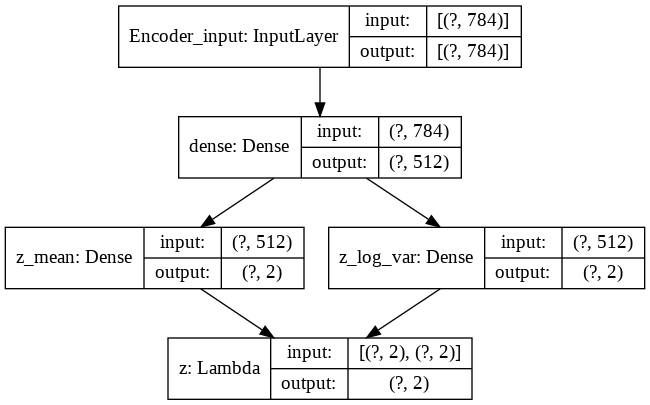

In [10]:
# Plot the Encoder Model
plot_model(encoder, to_file='vae_encoder.png', show_shapes=True)

In [11]:
# Create the Decoder Model
latent_inputs = Input(shape=(latent_dim), name='z_smapling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(orig_dim, activation='sigmoid')(x)

In [12]:
# Initialize the Decoder Model
decoder = Model(latent_inputs, outputs, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_smapling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


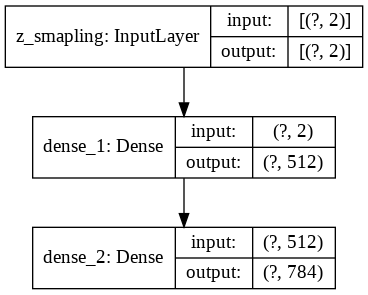

In [13]:
# Plot the Decoder Model
plot_model(decoder, to_file='vae_decoder.png', show_shapes=True)

In [14]:
# Initialize the VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='VAE')
  

Tensor("encoder/z/strided_slice:0", shape=(), dtype=int32)
2


Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 403972      Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder (Functional)            (None, 784)          403728      encoder[0][2]                    
__________________________________________________________________________________________________
tf_op_layer_Minimum (TensorFlow [(None, 784)]        0           Decoder[0][0]                    
________________________________________________________________________________________________

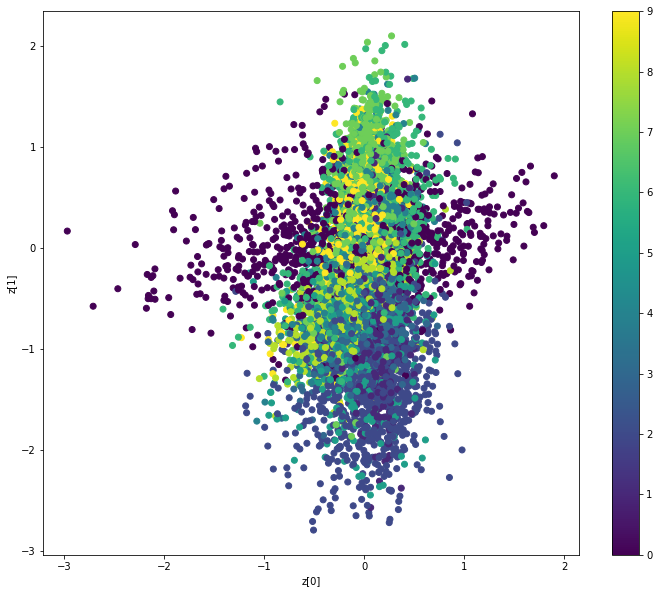

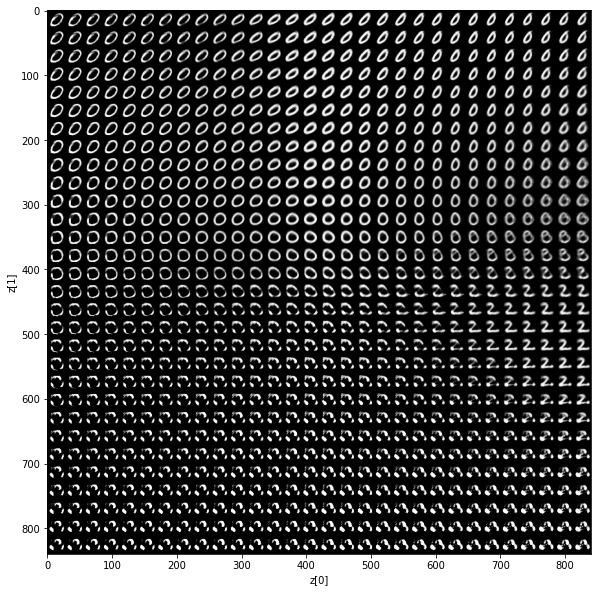

In [15]:
if __name__ == '__main__':
    models=(encoder, decoder)
    data=(x_test,y_test)

    reconstruction_loss = binary_crossentropy(inputs, outputs)
    reconstruction_loss = reconstruction_loss * orig_dim
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)    
    kl_loss = kl_loss * -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae, to_file='vae_enc_dec.png', show_shapes=True)
    
    
#     Train the AutoEncoder
    vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
    vae.save_weights('vae_mlp_mnist.h5')
    
    plot_results(models, data, batch_size=batch_size, model_name='vae_mlp')
    
    